In [1]:
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, Math

In [2]:
df = pd.read_csv('Train.csv', index_col=0)
df = df[['Size', 'TuneSize', 'GPUEpoch', 'GPUTime']]

df_base = df[df['TuneSize'] < 0]
df_tune = df[df['TuneSize'] > 0]

df_base_grouped = df_base.groupby('Size')
df_base_groupedsum = df_base_grouped.sum().reset_index()
df_base_groupedsum['Type'] = 'Base training'

df_tune_grouped = df_tune.groupby('TuneSize')
df_tune_groupedsum = df_tune_grouped.sum().reset_index()
df_tune_groupedsum['Size'] = df_tune_groupedsum['TuneSize']
df_tune_groupedsum['Type'] = 'Expert tuning'

df_plt = pd.concat([df_base_groupedsum, df_tune_groupedsum])

In [4]:
ds = {}
ds['Base'] = {}
ds['Tune'] = {}
for s in range(3, 11):
    ds['Base'][s] = [] 
    ds['Tune'][s] = [] 

for i in range(len(df_plt)):
    size = df_plt['Size'].iloc[i]
    tunesize = df_plt['TuneSize'].iloc[i]
    epoch = df_plt['GPUEpoch'].iloc[i]
    
    if tunesize > 0:
        for s in range(3, 11):
            if s == size:
                ds['Tune'][s] += [epoch]
    else:
        for s in range(3, 11):
            if s == size:
                if s==3:
                    ds['Base'][s] += [epoch]                    
                else:
                    ds['Base'][s] += [epoch/2]
            elif s < size:
                ds['Base'][s] += [epoch/2/(size-3)]


In [5]:
def appfun(size, tunesize, ds):
    if tunesize < 0:
        return sum(ds['Base'][size])
    else:
        return sum(ds['Tune'][size])

df_plt['GPUEpoch-Net'] = df_plt.apply(lambda row: appfun(row['Size'], row['TuneSize'], ds), axis=1)

In [8]:
# Define a custom formatter function
def format_y(value, tick_number):
    return f'{value / 1_000_000:.1f}M'

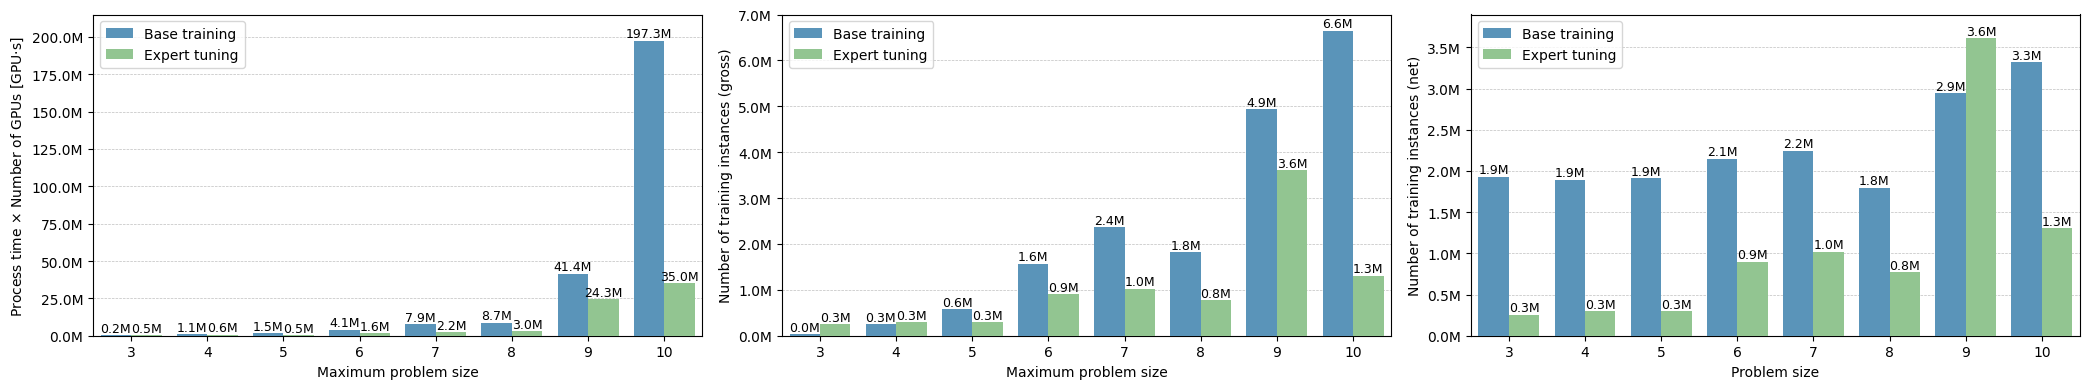

In [16]:
palette = {
    'Base training': sns.color_palette('Blues', 24)[14],
    'Expert tuning': sns.color_palette('Greens', 24)[10]}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 4))

# Plot on the first subplot
for ax, y in zip(axes, ['GPUTime', 'GPUEpoch', 'GPUEpoch-Net']):
    sns.barplot(ax=ax, data=df_plt, x='Size', y=y, palette=palette, hue='Type', zorder=5)

    if y == 'GPUTime':
        ax.set_ylabel(fr'Process time $\times$ Number of GPUs [GPU$\cdot$s]')
        # new_labels = ['3'] + [fr'$\leq${i}' for i in range(4, 11)]
        # ax.set_xticks(range(len(new_labels)))
        # ax.set_xticklabels(new_labels)
        ax.set_ylim([0, 215000000])
        ax.set_xlabel('Maximum problem size')
    if y == 'GPUEpoch':
        ax.set_ylabel(f'Number of training instances (gross)')
        ax.set_ylim([0, 7000000])
        ax.set_xlabel('Maximum problem size')
    if y == 'GPUEpoch-Net':
        ax.set_ylabel(f'Number of training instances (net)')
        ax.set_ylim([0, 3900000])
        ax.set_xlabel('Problem size')

    ax.yaxis.set_major_formatter(FuncFormatter(format_y))
    ax.grid(axis='y', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
    ax.legend(title=None)


    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(
                f'{p.get_height() / 1_000_000:.1f}M',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=9, 
                color='black', 
                xytext=(0, 5), 
                textcoords='offset points',
                zorder=11,
                rotation=0
            )

plt.tight_layout()
plt.savefig('output/training_cost.svg')
plt.show()